<a href="https://colab.research.google.com/github/suka94/ADM_HW5/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework 5 - The Marvel Universe!**

##**1. Data**

In [ ]:
import pandas as pd
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from random import sample
import re
from itertools import combinations
from collections import Counter
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read in the nodes data
nodes_df = pd.read_csv('/content/drive/MyDrive/ADM5/nodes.csv')
nodes_df.head()


,node,type
0,2001 10,comic
1,2001 8,comic
2,2001 9,comic
3,24-HOUR MAN/EMMANUEL,hero
4,3-D MAN/CHARLES CHAN,hero


In [ ]:
edges_df = pd.read_csv('/content/drive/MyDrive/ADM5/edges.csv')
edges_df.head()

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251


In [ ]:
hero_network_df = pd.read_csv('/content/drive/MyDrive/ADM5/hero-network.csv')
hero_network_df.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [ ]:
hero_network_df['hero1'] = hero_network_df['hero1'].str.strip().str.replace(' /', ' ')
hero_network_df['hero2'] = hero_network_df['hero2'].str.strip().str.replace(' /', ' ')
hero_network_df['hero1'] = hero_network_df['hero1'].str.strip().str.replace('/ ', ' ')
hero_network_df['hero2'] = hero_network_df['hero2'].str.strip().str.replace('/ ', ' ')
hero_network_df['hero1'] = hero_network_df['hero1'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')
hero_network_df['hero2'] = hero_network_df['hero2'].replace('SPIDER-MAN/PETER PAR', 'SPIDER-MAN/PETER PARKER')


In [ ]:
# Remove self-loops from hero_network_df
hero_network_df = hero_network_df[hero_network_df['hero1'] != hero_network_df['hero2']]

hero_network_df.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [ ]:
collaboration_counts = defaultdict(int)
G1 = nx.MultiDiGraph()

for _, row in hero_network_df.iterrows():
    hero1, hero2 = row['hero1'], row['hero2']
    collaboration_counts[(hero1, hero2)] += 1
    # Add the two hero nodes to the graph if they don't already exist
    if hero1 not in G1:
        G1.add_node(hero1)
    if hero2 not in G1:
        G1.add_node(hero2)
    # Add an edge between the two hero nodes with a weight equal to the number of collaborations
    count = collaboration_counts[(hero1, hero2)]
    G1.add_edge(hero1, hero2, weight=count)

In [ ]:
G2 = nx.Graph()

for _, row in nodes_df.iterrows():
    G2.add_node(row['node'], type=row['type'])


In [ ]:
for _, row in edges_df.iterrows():
    G2.add_edge(row['hero'], row['comic'])


In [ ]:
nx.write_gml(G1, '/content/drive/MyDrive/ADM5/G1.gml')
nx.write_gml(G2, '/content/drive/MyDrive/ADM5/G2.gml')

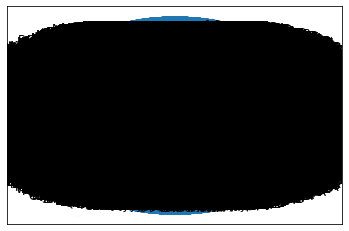

In [ ]:
# Load the graph from the GML file
G1 = nx.read_gml('/content/drive/MyDrive/ADM5/G1.gml')

# Use the spring layout to position the nodes
pos = nx.circular_layout(G1)

# Draw the nodes and edges
nx.draw_networkx(G1, pos)

# Show the plot
plt.show()

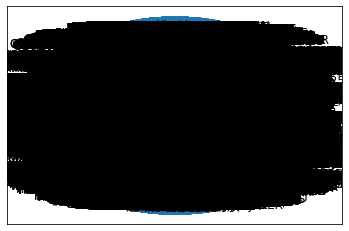

In [ ]:
# Load the graph from the GML file
G2 = nx.read_gml('/content/drive/MyDrive/ADM5/G2.gml')

# Use the spring layout to position the nodes
pos = nx.circular_layout(G2)

# Draw the nodes and edges
nx.draw_networkx(G2, pos)

# Show the plot
plt.show()

##**2. Backend Implementation**

In [ ]:
# Solve version conflict between networkx and scipy when using pagerank
import scipy
import subprocess
import sys

if int(scipy.__version__[2]) < 8:
  subprocess.check_call([sys.executable,"-m", "pip", "install", "scipy==1.8.0"])
  print('IMPORTANT: RESTART RUNTIME BEFORE CONTINUING')
  print(scipy.__version__)

IMPORTANT: RESTART RUNTIME BEFORE CONTINUING
1.7.3


In [ ]:
def get_top_N_heroes(G, type_, N, with_degrees=False):
  out = []

  if type_ == 1:
    # find number of comics per hero
    collaborations = defaultdict(int)
    for node in G.nodes():
      collaborations[node] = sum([G[node][neighbor]['count'] for neighbor in G.neighbors(node)])
    # sort them
    collaborations = dict(sorted(collaborations.items(), key = lambda x: x[1], reverse=True))
    # take top N
    out = [el[0] for el in list(collaborations.items())[:N]]


  if type_ == 2:
    # find number of comics per hero (aka degrees)
    degrees = sorted(G.degree, key=lambda x: x[1], reverse=True) 
    if with_degrees:
      out = [el for el in degrees if G.nodes[el[0]]['type'] == 'hero'][:N]
    else:
      out = [el[0] for el in degrees if G.nodes[el[0]]['type'] == 'hero'][:N]
  
  return out

In [ ]:
def functionality_1(G, type_, N = None):
  
  if type_ == 1:
    if N:
      G = G.subgraph(get_top_N_heroes(G, type_, N))
    degrees = list(map(lambda x: x[1], G.degree))
    # number of nodes
    n_nodes = G.number_of_nodes()
    # collaborations
    pairs = list(combinations(list(G.nodes()), 2))
    collaborations = defaultdict(int)
    for el in pairs:
      try:
        collaborations[el] = G[el[0]][el[1]]['count']
      except:
        pass
    # density
    density = nx.density(G)
    # degree distribution
    degree_distro = Counter(degrees)
    # average degree
    average_degree = np.mean(np.array(degrees))
    # hubs
    _95_percentile = np.percentile(np.array(degrees), 95)
    hubs = [(key, value) for key, value in G.degree if value > _95_percentile]
    # sparse or dense
    if density > .5:
      sparse = False
    else:
      sparse = True

    out = {'n_nodes': n_nodes,
           'collaborations': collaborations,
           'density': density,
           'degree_distribution': degree_distro,
           'avg_degree': average_degree,
           'hubs': hubs,
           'sparse': sparse}

    
  if type_ == 2:
    if N:
      top_N_heroes = get_top_N_heroes(G, type_, N)    
      top_N_heroes_with_respective_comics = set(top_N_heroes)
      for hero in top_N_heroes:
        top_N_heroes_with_respective_comics = top_N_heroes_with_respective_comics.union(set(G.neighbors(hero)))
      G = G.subgraph(list(top_N_heroes_with_respective_comics))
    heroes = [x for x,y in G.nodes(data=True) if y['type']=='hero']
    comics = [x for x,y in G.nodes(data=True) if y['type']=='comic']
    # number of nodes
    n_heroes = len(heroes)
    n_comics = len(comics)
    # number of heroes that have appeared in each comic
    heroes_in_comics = defaultdict(int)
    for el in comics:
      heroes_in_comics[el] = G.degree[el]
    # density
    density = len(G.edges()) / (n_heroes * n_comics)
    # degree distribution
    comics_degrees = [G.degree(el) for el in comics]
    degree_distro = Counter(comics_degrees)
    # average degree
    average_degree = np.mean(np.array(comics_degrees))
    # hubs
    _95_percentile = np.percentile(np.array(comics_degrees), 95)
    hubs = [(comic, G.degree(comic)) for comic in comics if G.degree(comic) > _95_percentile]
    # sparse or dense
    if density > .5:
      sparse = False
    else:
      sparse = True

    out = {'n_hero_nodes': n_heroes,
           'n_comics_nodes': n_comics,
           'heroes_in_comics': heroes_in_comics,
           'density': density,
           'comics_degree_distribution': degree_distro,
           'comics_avg_degree': average_degree,
           'comics_hubs': hubs,
           'sparse': sparse}

  return out


In [ ]:
def functionality_2(G, type_, node, metric, N = None):
  if type_ == 1 and N:
    G = G.subgraph(get_top_N_heroes(G, type_, N))
  if type_ == 2 and N:
    top_N_heroes = get_top_N_heroes(G, type_, N)    
    top_N_heroes_with_respective_comics = set(top_N_heroes)
    for hero in top_N_heroes:
      top_N_heroes_with_respective_comics = top_N_heroes_with_respective_comics.union(set(G.neighbors(hero)))
    G = G.subgraph(list(top_N_heroes_with_respective_comics))

  if metric.lower() == 'betweeness':
    graph_betweness_centrality = nx.betweenness_centrality(G, normalized=True)
    node_betweeness_centrality = graph_betweness_centrality[node]
    return graph_betweness_centrality, node_betweeness_centrality
  if metric.lower() == 'pagerank':  
    graph_pagerank = nx.pagerank(G)
    node_pagerank = graph_pagerank[node]
    return graph_pagerank, node_pagerank
  if metric.lower() == 'closenesscentrality':
    graph_closeness = nx.closeness_centrality(G)
    node_closeness = graph_closeness[node]
    return graph_closeness, node_closeness
  if metric.lower() == 'degreecentrality':
    graph_degree = nx.degree(G)
    node_degree = graph_degree[node]
    return graph_degree, node_degree

In [ ]:
def BFS(G, s, t, parent):
  visited = dict(zip(list(G.nodes()), [False]*G.number_of_nodes()))
  queue=[]
  queue.append(s)
  visited[s] = True
 
  while queue:
    u = queue.pop(0)
    for v in G.neighbors(u):
      if visited[v] == False and G[u][v]['weight'] > 0 :
        queue.append(v)
        visited[v] = True
        parent[v] = u
  return True if visited[t] else False

def DFS(G,s,visited):
  visited[s] = True
  for node in G.neighbors(s):
    if G[s][node]['weight'] > 0 and not visited[node]:
      DFS(G ,node ,visited)

def functionality_4(G, source, sink, N = None):
  if N:
    G = G.subgraph(get_top_N_heroes(G, 1, N))
  if G.number_of_nodes() > 1000:
    sys.setrecursionlimit(G.number_of_nodes() + 1)
  G = G.to_directed()
  G_copy = G
  parent = defaultdict(str)
  max_flow = 0
  while BFS(G, source, sink, parent):    
    path_flow = float("Inf")
    s = sink
    while(s != source):
      path_flow = min(path_flow, G[parent[s]][s]['weight'])
      s = parent[s]
    max_flow += path_flow
  

    v = sink
    while(v != source):
      u = parent[v]
      G[u][v]['weight'] -= path_flow
      G[v][u]['weight'] += path_flow
      v = parent[v]

  visited = dict(zip(list(G.nodes()), [False]*G.number_of_nodes()))
  DFS(G, s, visited)

  min_cut = []
  for edge in G.edges():
    i, j = edge
    if G[i][j]['weight'] == 0 and visited[i] and not visited[j]:
      min_cut.append((i,j))
  
  return len(min_cut), min_cut, max_flow   # you can also return min_cut and max_flow

##**3. Frontend Implementation**

reading the network from Pandas Dataframe to avoid problems with special characters

In [ ]:
hero1_hero2_frame = pd.read_csv('/content/drive/MyDrive/ADM5/hero-network.csv', sep=',')
hero_comic_frame = pd.read_csv('/content/drive/MyDrive/ADM5/edges.csv', sep=',')
node_type_frame = pd.read_csv('/content/drive/MyDrive/ADM5/nodes.csv', sep=',')

In [ ]:
hero_comic_frame

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35
1,3-D MAN/CHARLES CHAN,AVF 4
2,3-D MAN/CHARLES CHAN,AVF 5
3,3-D MAN/CHARLES CHAN,COC 1
4,3-D MAN/CHARLES CHAN,H2 251
...,...,...
96099,ZZZAX,H2 326
96100,ZZZAX,H2 327
96101,ZZZAX,M/CP 8/4
96102,ZZZAX,PM 47


creating the three graphs

In [ ]:
hero1_hero2 = nx.from_pandas_edgelist(hero1_hero2_frame, "hero1", "hero2")
hero_comic = nx.from_pandas_edgelist(hero_comic_frame, "hero", "comic")
node_type = nx.from_pandas_edgelist(node_type_frame, "node", "type")

#Visualization 1 - Visualize some features of the network

considering the network as undirected

In [ ]:
print(hero1_hero2)

Graph with 6426 nodes and 167219 edges


In [ ]:
visualization1 = pd.DataFrame(columns = ['number_of_nodes', 'density', 'avg_degree_centrality', 'sparse_or_dense'])

In [ ]:
visualization1.loc['type_of_graph: hero1-hero2', 'number_of_nodes'] = nx.number_of_nodes(hero1_hero2)
visualization1.loc['type_of_graph: hero1-hero2', 'density'] = nx.density(hero1_hero2)
visualization1.loc['type_of_graph: hero1-hero2', 'avg_degree_centrality'] = round(sum([degree for (_, degree) in hero1_hero2.degree()]) / nx.number_of_nodes(hero1_hero2), 2)
visualization1.loc['type_of_graph: hero1-hero2', 'sparse_or_dense'] = np.where(nx.density(hero1_hero2) > 0.5, 'dense', 'sparse')

visualization1.loc['type_of_graph: hero-comic', 'number_of_nodes'] = nx.number_of_nodes(hero_comic)
visualization1.loc['type_of_graph: hero-comic', 'density'] = nx.density(hero_comic)
visualization1.loc['type_of_graph: hero-comic', 'avg_degree_centrality'] = round(sum([degree for (_, degree) in hero_comic.degree()]) / nx.number_of_nodes(hero_comic), 2)
visualization1.loc['type_of_graph: hero-comic', 'sparse_or_dense'] = np.where(nx.density(hero_comic) > 0.5, 'dense', 'sparse')

visualization1.loc['type_of_graph: node-type', 'number_of_nodes'] = nx.number_of_nodes(node_type)
visualization1.loc['type_of_graph: node-type', 'density'] = nx.density(node_type)
visualization1.loc['type_of_graph: node-type', 'avg_degree_centrality'] = round(sum([degree for (_, degree) in node_type.degree()]) / nx.number_of_nodes(node_type), 2)
visualization1.loc['type_of_graph: node-type', 'sparse_or_dense'] = np.where(nx.density(node_type) > 0.5, 'dense', 'sparse')

In [ ]:
visualization1

,number_of_nodes,density,avg_degree_centrality,sparse_or_dense
type_of_graph: hero1-hero2,6426,0.0081,52.04,sparse
type_of_graph: hero-comic,19090,0.000527,10.07,sparse
type_of_graph: node-type,19092,0.000105,2.0,sparse


# A table that lists the network's hubs


In [ ]:
avg_degree_centrality = visualization1.iloc[0,2]

degrees_each_hero = {hero:degree for (hero, degree) in hero1_hero2.degree()}

hubs = {hero:degree for (hero, degree) in degrees_each_hero.items() if degree > avg_degree_centrality}
print('Lenght of hubs'' list:', len(hubs))
# print(hubs)

Lenght of hubs list: 1444


# A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)


In [ ]:
collaborations = hero_comic_frame.groupby('hero')['comic'].size()
collaborations = (collaborations.sort_values(ascending=False)).to_frame()
collaborations.reset_index(inplace=True)

collaborations.rename(columns={collaborations.columns[1]: 'number_of_collaboration'}, inplace=True)

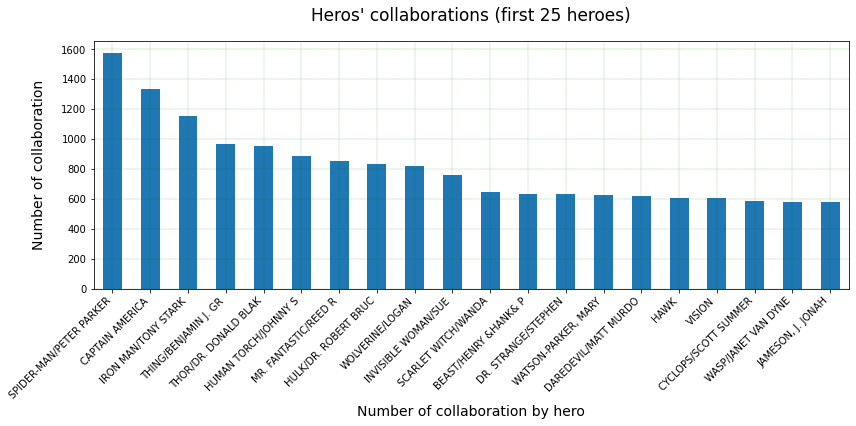

In [ ]:
# showing the first 25 heros for visualization reason

plt.rcParams['figure.figsize'] = [12, 6]

ax = collaborations.iloc[:20,:].plot( y = "number_of_collaboration", x = "hero", kind = "bar")

plt.xticks(rotation=45, fontsize=10, ha='right')
plt.xlabel("Number of collaboration by hero", fontsize= 14)
plt.ylabel("Number of collaboration", fontsize=14, labelpad=15)
plt.title("Heros' collaborations (first 25 heroes)", fontsize= 17, pad =20)
plt.tight_layout(pad=1)
plt.legend('', frameon=False)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)

plt.show()

# A plot depicting the degree distribution of the network (first kind of graph)

In [ ]:
degree_sequence = sorted([d for n, d in hero1_hero2.degree()], reverse=True)

In [ ]:
degree_sequence = pd.DataFrame(degree_sequence).astype(str)
degree_sequence.rename(columns={degree_sequence.columns[0]: 'degree'}, inplace=True)

In [ ]:
degree_sequence_grouped = degree_sequence.groupby('degree').size()

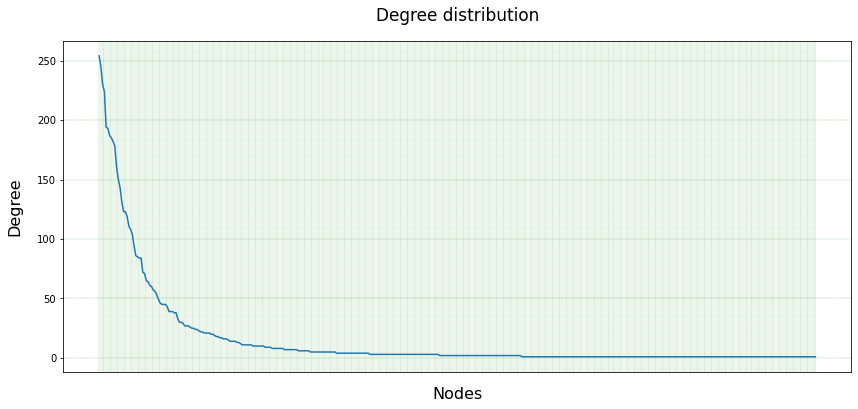

In [ ]:
plt.close()
plt.plot(degree_sequence_grouped.sort_values(ascending=False))

plt.ylabel("Degree", fontsize=16, labelpad=15)
plt.xlabel("Nodes", fontsize=16, labelpad=15)
plt.title("Degree distribution", fontsize= 17, pad =20)
plt.tight_layout(pad=1)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.2)
plt.tick_params(labelbottom = False, bottom = False)

plt.show()

# Visualization 2 - Visualize centrality measure

In [ ]:
visualization2 = pd.DataFrame(columns = ['degree_centrality', 'eigenvector_centrality', 
                                         'closeness_centrality', 'betweenness_centrality'])
# creating dictionaries for all possible nodes
# created also for computational reason
eigen_centrality = nx.eigenvector_centrality_numpy(hero1_hero2)
closeness_centrality = nx.closeness_centrality(hero1_hero2)
betweenness_centrality = nx.betweenness_centrality(hero1_hero2)
page_rank = nx.pagerank(hero1_hero2)

## example of node you can chose

In [ ]:
print('Samples from first kind of network:\n',sample(list(hero1_hero2.nodes), 8))

# copy and paste the node's name from the print output example
selected_node = 'LORD CHAOS'

Samples from first kind of network:
 ['SOUL MAN/FATHER JASO', 'TAI II', 'QNAX', 'SHAW, SHINOBI', 'RIOT II/', 'BRAHMANES', 'CROMWELL, HAMILTON', 'MOTHER INFERIOR']


In [ ]:
visualization2.loc['average values of all nodes', 'degree_centrality'] = np.mean(list(nx.degree_centrality(hero1_hero2).values()))
visualization2.loc['average values of all nodes', 'eigenvector_centrality'] = np.mean(list(eigen_centrality.values()))
visualization2.loc['average values of all nodes', 'closeness_centrality'] = np.mean(list(closeness_centrality.values()))
visualization2.loc['average values of all nodes', 'betweenness_centrality'] = np.mean(list(betweenness_centrality.values()))

In [ ]:
visualization2

,degree_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality
average values of all nodes,0.0081,0.006047,0.381307,0.000254


In [ ]:
visualization2_2 = pd.DataFrame(columns = ['degree', 'page_rank', 
                                           'closeness_centrality', 'betweenness_centrality'])

In [ ]:
visualization2_2.loc[f'chosen node: {selected_node}', 'degree'] = nx.degree(hero1_hero2, selected_node)
visualization2_2.loc[f'chosen node: {selected_node}', 'page_rank'] = page_rank[selected_node]
visualization2_2.loc[f'chosen node: {selected_node}', 'closeness_centrality'] = nx.closeness_centrality(hero1_hero2, u = selected_node)
visualization2_2.loc[f'chosen node: {selected_node}', 'betweenness_centrality'] = betweenness_centrality[selected_node]

In [ ]:
visualization2_2

,degree,page_rank,closeness_centrality,betweenness_centrality
chosen node: LORD CHAOS,135,0.000314,0.468165,0.000109


# Visualization 3 - Visualize the shortest-ordered route

In [ ]:
print('Possible start node:\n', hero_comic_frame['hero'].sample(5))
print('Possible end node:\n', hero_comic_frame['hero'].sample(5) )

# copy and paste the node's name from the print output example
start_node = '3-D MAN/CHARLES CHAN'
end_node = 'FIREBIRD/BONITA JUAR'

Possible start node:
 66450              REVER, DAN
82326         TERRAX II/TYROS
73918    SILVER SURFER/NORRIN
57685    NIGHT THRASHER/DUANE
84570    THOR/DR. DONALD BLAK
Name: hero, dtype: object
Possible end node:
 20891          D'KEN [SHI'AR]
51876    MEDUSA/MEDUSALITH AM
90798            WATSON, ANNA
7930      BLACK WIDOW/NATASHA
4821            BEACH, GINGER
Name: hero, dtype: object


In [ ]:
path = nx.shortest_path(hero_comic, source = start_node, target = end_node)

path_edges = list(zip(path, path[2:]))
path_edges = path_edges[::2]

path_nodes = list(path[0::2])
edges = path[1::2]

labels = {path_edges[i]:edges[i] for i in range(len(path_edges))}

In [ ]:
to_plot = nx.Graph()
to_plot.add_edges_from(path_edges)
pos = nx.spring_layout(to_plot)

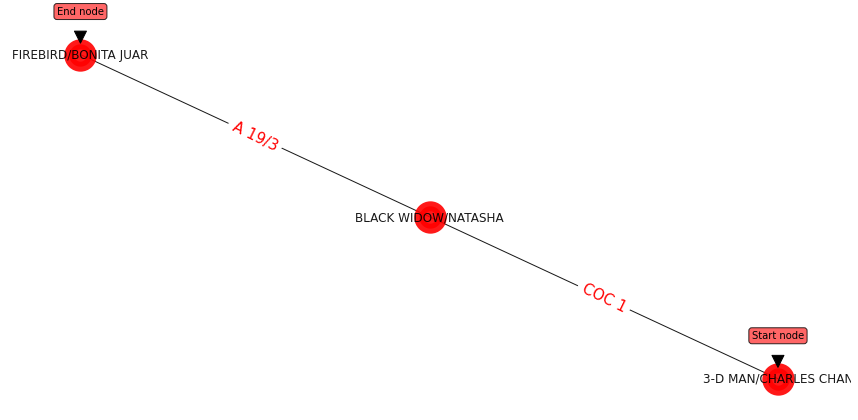

In [ ]:
plt.figure()
ax = plt.gca()

nx.draw(
    to_plot, pos, edge_color='black', width=1, linewidths=10,
    node_size=500, node_color='red', alpha=0.9,  font_size = 12,
    labels = {node: node for node in to_plot.nodes()})

nx.draw_networkx_edge_labels(to_plot, pos, edge_labels = labels, font_color='red', font_size=15)

ax.annotate("Start node", xy=pos.get(start_node), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

ax.annotate("End node", xy=pos.get(end_node), xytext=(0, 40), textcoords='offset points',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

plt.tight_layout(pad=1)

plt.show()

# Visualization 4 - Visualize the disconnected graph

In [ ]:
shrinked_graph = hero1_hero2_frame.iloc[:,:]
hero1_hero2 = nx.from_pandas_edgelist(shrinked_graph, "hero1", "hero2")

## to make sure hero_A and hero_B are connected
## we are using a shrinked GiantComponent, where all the heros present are connected
## best visualization with 15 heroes

In [ ]:
giant_component = sorted(nx.connected_components(hero1_hero2), key=len, reverse=True) # True ---> gian component
giant_component = hero1_hero2.subgraph(giant_component[0])

In [ ]:
giant_component = nx.to_pandas_edgelist(giant_component)

In [ ]:
giant_component = giant_component.iloc[:30, :]
giant_component = nx.from_pandas_edgelist(giant_component, "source", "target")

In [ ]:
print('Possible start node:\n', giant_component.nodes())

Possible start node:
 ['LITTLE, ABNER', 'PRINCESS ZANDA', "BLACK PANTHER/T'CHAL", 'CARNIVORE/COUNT ANDR', 'IRON MAN/TONY STARK ', 'GOLDEN-BLADE', 'DIXON, GENERAL', 'IRON MAN IV/JAMES R.', 'JOCASTA', 'FUJIKAWA, RUMIKO', 'MADAME MENACE/SUNSET', 'JACOBS, GLENDA', 'WAR MACHINE II/PARNE', 'SAPPER', 'HOGAN, VIRGINIA PEPP', 'BINARY/CAROL DANVERS', 'FIN FANG FOOM/MIDGAR', 'MANN, DR. J. VERNON ', 'THOR/DR. DONALD BLAK', 'TEMPEST II/NICOLETTE', 'JARVIS, EDWIN ', 'INFERNO III/SAMANTHA', 'DECAY II/YOSHIRO HAC']


In [ ]:
hero_A = 'LITTLE, ABNER' # related to subgraph A
hero_B = 'PRINCESS ZANDA' # related to subgraph B

In [ ]:
# minimum_cut_edge = dict(nx.minimum_edge_cut(giant_component, s = hero_A, t = hero_B))
from networkx.algorithms.connectivity import minimum_st_edge_cut
minimum_cut_edge = dict(minimum_st_edge_cut(giant_component, s = hero_A, t = hero_B))
print(minimum_cut_edge)
minimum_cut = len(nx.minimum_edge_cut(giant_component, s = hero_A, t = hero_B))
print('\nThe minimum edge cut, for separating the original graph in two distinct subgraph is:', minimum_cut)

{'HOGAN, VIRGINIA PEPP': 'PRINCESS ZANDA', 'IRON MAN/TONY STARK ': 'PRINCESS ZANDA', 'LITTLE, ABNER': 'PRINCESS ZANDA', 'TEMPEST II/NICOLETTE': 'PRINCESS ZANDA', 'MANN, DR. J. VERNON ': 'PRINCESS ZANDA', 'THOR/DR. DONALD BLAK': 'PRINCESS ZANDA', 'CARNIVORE/COUNT ANDR': 'PRINCESS ZANDA', "BLACK PANTHER/T'CHAL": 'PRINCESS ZANDA', 'JARVIS, EDWIN ': 'PRINCESS ZANDA'}

The minimum edge cut, for separating the original graph in two distinct subgraph is: 9


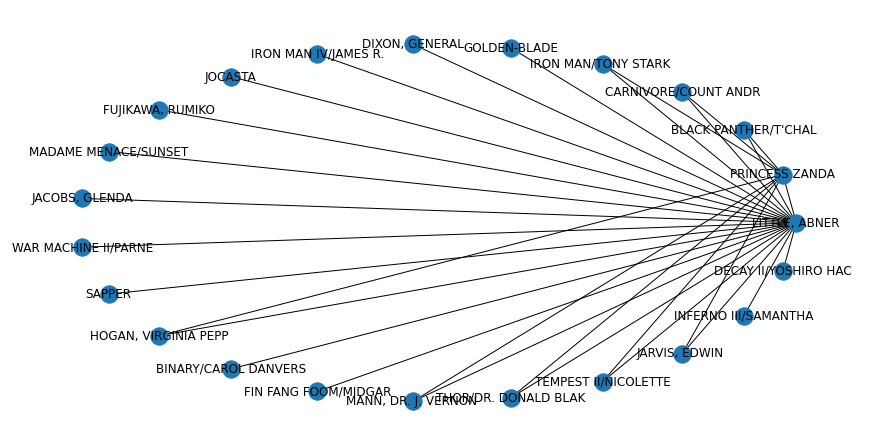

In [ ]:
nx.draw_circular(giant_component, labels = {node: node for node in giant_component.nodes()})

In [ ]:
minimum_cut_edge = [(k, v) for k, v in minimum_cut_edge.items()]
print(minimum_cut_edge)

[('HOGAN, VIRGINIA PEPP', 'PRINCESS ZANDA'), ('IRON MAN/TONY STARK ', 'PRINCESS ZANDA'), ('LITTLE, ABNER', 'PRINCESS ZANDA'), ('TEMPEST II/NICOLETTE', 'PRINCESS ZANDA'), ('MANN, DR. J. VERNON ', 'PRINCESS ZANDA'), ('THOR/DR. DONALD BLAK', 'PRINCESS ZANDA'), ('CARNIVORE/COUNT ANDR', 'PRINCESS ZANDA'), ("BLACK PANTHER/T'CHAL", 'PRINCESS ZANDA'), ('JARVIS, EDWIN ', 'PRINCESS ZANDA')]


In [ ]:
disconnected_hero = giant_component.copy()
disconnected_hero.remove_edges_from(minimum_cut_edge)

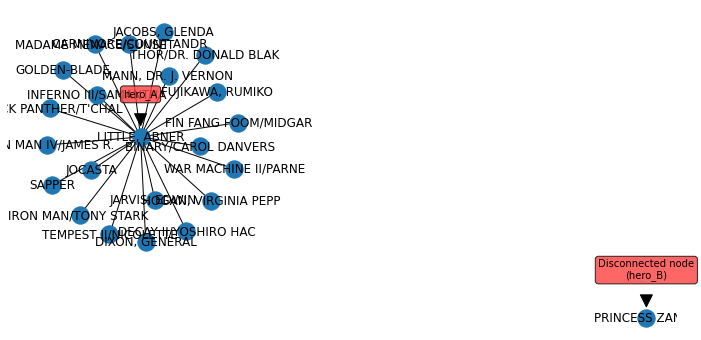

In [ ]:
plt.figure()
ax = plt.gca()

pos = nx.spring_layout(disconnected_hero)
nx.draw(disconnected_hero, pos, labels = {node: node for node in disconnected_hero.nodes()})

ax.annotate("Disconnected node\n(hero_B)", xy=pos.get(hero_B), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

ax.annotate("hero_A", xy=pos.get(hero_A), xytext=(0, 40), textcoords='offset pixels',
    arrowprops=dict(facecolor='black', shrink=0.3), bbox=dict(boxstyle="round", fc='#FF4040', alpha=0.8), ha='center')

plt.show()

# Visualization 5 - Visualize the communities
## Girvan_newman method is implemented thanks to Networkx

In [ ]:
from networkx.algorithms import community

# communities = hero1_hero2_frame.iloc[200,:]
# communities = nx.from_pandas_edgelist(giant_component, 'hero1', 'hero2')

communities = nx.community.girvan_newman(giant_component)
communities_frame = pd.DataFrame(communities)
communities_frame

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,"{PRINCESS ZANDA, IRON MAN IV/JAMES R., HOGAN, ...",{GOLDEN-BLADE},None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"{PRINCESS ZANDA, IRON MAN IV/JAMES R., HOGAN, ...",{GOLDEN-BLADE},"{DIXON, GENERAL}",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"{PRINCESS ZANDA, HOGAN, VIRGINIA PEPP, TEMPEST...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,"{PRINCESS ZANDA, HOGAN, VIRGINIA PEPP, TEMPEST...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,"{FIN FANG FOOM/MIDGAR, PRINCESS ZANDA, IRON MA...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,"{FIN FANG FOOM/MIDGAR, PRINCESS ZANDA, IRON MA...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,"{FIN FANG FOOM/MIDGAR, PRINCESS ZANDA, IRON MA...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",None,None,...,None,None,None,None,None,None,None,None,None,None
7,"{FIN FANG FOOM/MIDGAR, PRINCESS ZANDA, IRON MA...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",{WAR MACHINE II/PARNE},None,...,None,None,None,None,None,None,None,None,None,None
8,"{FIN FANG FOOM/MIDGAR, PRINCESS ZANDA, IRON MA...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",{WAR MACHINE II/PARNE},{SAPPER},...,None,None,None,None,None,None,None,None,None,None
9,"{FIN FANG FOOM/MIDGAR, PRINCESS ZANDA, IRON MA...",{GOLDEN-BLADE},"{DIXON, GENERAL}",{IRON MAN IV/JAMES R.},{JOCASTA},"{FUJIKAWA, RUMIKO}",{MADAME MENACE/SUNSET},"{JACOBS, GLENDA}",{WAR MACHINE II/PARNE},{SAPPER},...,None,None,None,None,None,None,None,None,None,None


##**5. Bonus**

PageRank algorithm using the iterative MapReduce approach, based on the reference material provided:

In [ ]:
from collections import defaultdict

def pageRankIterativeMapReduce(pages, numIterations):
  for i in range(numIterations):
    pages = pageRankMapReduce(pages)
  return pages

def pageRankMapReduce(pages):
  # Map phase
  contributions = defaultdict(float)
  for page in pages:
    for q in page.outboundLinks:
      contributions[q] += page.rank / len(page.outboundLinks)
  # Reduce phase
  for page in pages:
    page.rank = (1 - DAMPING_FACTOR) / len(pages)
    for q in page.inboundLinks:
      page.rank += DAMPING_FACTOR * contributions[q] / len(q.outboundLinks)
  return pages


In this implementation, the pageRankMapReduce function represents a single iteration of the PageRank algorithm. The pageRankIterativeMapReduce function runs multiple iterations of the algorithm by calling pageRankMapReduce in a loop.

The PageRank algorithm is an iterative process that is used to rank the importance of pages on the internet. The algorithm assigns a score (called the "PageRank") to each page, based on the number and quality of links pointing to the page. Pages with a higher PageRank are considered more important and are more likely to appear at the top of search results.

The pageRankMapReduce function has two phases: the map phase and the reduce phase.

In the map phase, the function iterates over the pages and calculates a contribution to the rank of each page that the current page links to. The contribution is equal to the current page's rank divided by the number of outbound links it has. These contributions are stored in a defaultdict with the page as the key and the contribution as the value.

In the reduce phase, the function iterates over the pages again and updates each page's rank using the contributions stored in the defaultdict. The rank of each page is updated using the following formula:

page.rank = (1 - DAMPING_FACTOR) / len(pages) + DAMPING_FACTOR * sum(contributions[q] / len(q.outboundLinks) for q in page.inboundLinks)

This formula combines the damping factor (which determines the importance of the page's own rank versus the ranks of the pages it links to), the number of pages, and the contributions from the pages that link to the current page.

 DAMPING_FACTOR is a damping factor that is used to damp the influence of pages that have a lot of outbound links. It is a constant with a value between 0 and 1, typically set to 0.85. The idea behind the damping factor is to prevent pages with many outbound links from having too much influence on the PageRank of other pages.

Finally, the function returns the updated list of pages.

##**6. Algorithmic Question**

The idea is to create a **grid graph 3x3** with the library **NetworkX** and obtain all possible simple paths (i.e. paths with no repeated nodes) between pairs of nodes using  and consider the tuples indicating the nodes as coordinates. In this way we can take the tuple pairs in the individual paths and convert them into lists of strings with directions and then count the  complete matches of the input with the paths available.

In [ ]:
#import needed libraries
import networkx as nx
import matplotlib.pyplot as plt

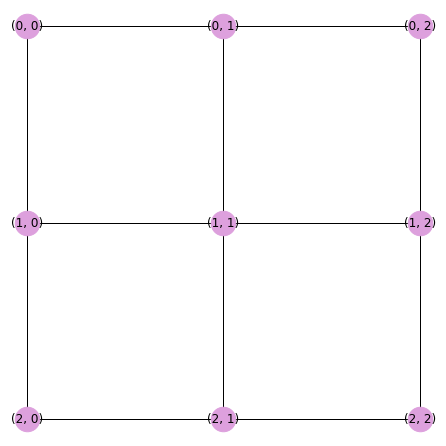

In [ ]:
#create a 2D grid graph
G = nx.grid_2d_graph(3,3)
#plot it
plt.figure(figsize=(6,6))
pos = {(x,y):(y,-x) for x,y in G.nodes()}
nx.draw(G, pos=pos, 
        node_color='plum', 
        with_labels=True,
        node_size=600)

In [ ]:
G.nodes #check nodes name that could be used as coordinates

NodeView(((0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)))

In [ ]:
#create a dictionary to store the paths for each pair of nodes
paths = {}

#compute the simple paths between all pairs of nodes
for node1 in G.nodes:
    for node2 in G.nodes:
        if node1 != node2:  #skip pairs of the same node
            simple_paths = list(nx.all_simple_paths(G, node1, node2))
            #store the paths in the path dictionary using the tuple of nodes as key
            paths[(node1, node2)] = simple_paths


**The rationale used provides that:**


-If the first coordinate of the first and the second node are is equal and the second is greater in the case of the second node the movement will be to the right (R) or otherwise it will be to te left (L).


-If the second coordinate of the first and second node are equal while the first is greater in the second node the movement will be down (D) otherwise up (U).

In [ ]:
#create a new dictionary to store the paths in terms of directions
direction_paths = {}

#iterate over the keys and values in the paths dictionary
for (node1, node2), paths in paths.items():
    direction_paths_ = []
    #iterate over the paths
    for path in paths:
        directions = []
        #iterate over the nodes in the path
        for i in range(len(path) - 1):
            current_node = path[i]
            next_node = path[i + 1]
            #find directions associated to a couple of nodes in each path
            if current_node[0] == next_node[0] and next_node[1] > current_node[1]:
                direction = 'R' #right
            elif current_node[0] == next_node[0] and next_node[1] < current_node[1]:
                direction = 'L' #left
            elif current_node[1] == next_node[1] and next_node[0] > current_node[0]:
                direction = 'D' #down
            elif current_node[1] == next_node[1] and next_node[0] < current_node[0]:
                direction = 'U' #up
            directions.append(direction)
        direction_paths_.append(directions)
    #store the list of direction paths for this pair of nodes in the dictionary
    direction_paths[(node1, node2)] = direction_paths_ 

The created dictionary contains duplicates that cannot match with the possible inputs so it's necessary to remove adjacent duplicate letters

In [ ]:
#create a new dictionary to store the deduplicated paths
deduplicated_paths = {}

#iterate over the keys and values in the direction_paths dictionary
for (node1, node2), paths in direction_paths.items():
    deduplicated_paths_ = []
    #iterate over the paths
    for path in paths:
        deduplicated_path = [letter for i, letter in enumerate(path) if path[i] != path[i-1]]
        deduplicated_paths_.append(deduplicated_path)
    #store the list of deduplicated paths for this pair of nodes in the dictionary
    deduplicated_paths[(node1, node2)] = deduplicated_paths_


#### Function to count paths given as input the deduplicated dictionary and an input string

In [ ]:
#create a function that given an input returns the number of paths
def count_paths(dedup_paths, input_string):
    count = 0
    #iterate over the keys and values in the direction_paths dictionary
    for (node1, node2), paths in deduplicated_paths.items():
    #iterate over the paths
        for path in paths:
        #check if the input string is equal to the path tranformed from list to string
            if input_string =="".join(path):
            #add one to the counter
                count+=1
            
    return count


#### Try with different inputs

In [ ]:
input_string = input()
dedup_paths = deduplicated_paths
count_paths(dedup_paths, input_string)

DRU


15

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

R


9

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

LDRDRUL


0

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

ULDR


9

In [ ]:
input_string = input()
count_paths(dedup_paths, input_string)

RDULULRD


0